### "Шапка" с названием проекта

В этой ячейке вы найдете оглавление и ключевые этапы работы, которые помогут вам ориентироваться в процессе выполнения проекта. Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) вам предлагается выполнить в этом Jupyter Notebook:

- Подготовка среды MLflow - Первый шаг, подготовка и запуск сервисов MLflow, был выполнен вне ноутбука и оформлен в виде shell скрипта. Это основа для работы с экспериментами и логирования результатов ваших моделей.

- Этап 2 - Исследовательский Анализ Данных (EDA): На этом этапе вы проведете тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация Признаков и Обучение Модели: После анализа данных вы сгенерируете новые признаки и обучите модель, используя эти признаки.

- Этап 4 - Отбор Признаков и Обучение Модели: На этом шаге вы отберете наиболее значимые признаки и снова обучите модель для улучшения ее качества.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.

Для удобства навигации и организации работы, пожалуйста, следуйте оглавлению и рекомендациям, описанным в каждом этапе.

> ### Важно: Переобучение моделей
> На каждом этапе проекта, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и, при необходимости, корректировку.

> ### Важно: Разделение выборок
> Перед началом выполнения вашего проекта важно правильно подготовить данные, разделив их на подвыборки. Это позволит оценить производительность модели более объективно и управлять риском переобучения. В зависимости от ваших целей и доступных данных, вы можете использовать различные стратегии разделения:

1. Разделение на train/val/test: Это классический подход, где данные делятся на три части. Обучающая выборка (train) используется для первичного обучения моделей, валидационная (val) - для настройки гиперпараметров и выбора лучшей модели, а тестовая (test) - для финальной оценки производительности модели. Такой подход идеален, если у вас достаточно данных, чтобы разделить их и каждая из выборок была репрезентативна.

2. Разделение на train/test с кросс-валидацией на train: Если данных недостаточно для трех подвыборок, можно ограничиться разделением на обучающую и тестовую выборки. В этом случае кросс-валидация на обучающей выборке поможет оценить стабильность модели и подобрать гиперпараметры.

Определение способа разделения данных: Выбор метода разбиения данных на подвыборки — train, validation и test — должен быть обоснован особенностями вашего набора данных и задачами проекта. Возможные методы разделения, включая различные стратегии и правила, подробно описаны в [документации scikit-learn по разбиению данных](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). Вы можете следовать этим примерам или разработать собственный метод, исходя из специфики ваших данных.

Ваша задача - выбрать подходящий метод разделения данных исходя из объема и специфики ваших данных. Помните, что финальные метрики качества модели мы будем оценивать на тестовой выборке. Промежуточные результаты после каждого этапа проекта (например, после настройки гиперпараметров) следует оценивать на валидационной выборке, если таковая имеется. Это поможет вам корректно настроить модель перед финальной оценкой её производительности.

### Импорты

In [2]:
import os

import psycopg
import pandas as pd
import numpy as np
from numpy import array

from statistics import median

import optuna
from optuna.samplers import TPESampler
from optuna.integration.mlflow import MLflowCallback
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    mean_absolute_percentage_error, 
    mean_absolute_error, 
    mean_squared_error,
    r2_score
)
from collections import defaultdict

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
)

import mlflow
import os
import json

from dotenv import load_dotenv, find_dotenv

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# сделайте разделение изначального набора данных в этой ячейке
# подгружаем .env

load_dotenv()

True

In [5]:
# Считываем все креды
src_host = os.environ.get('DB_SOURCE_HOST')
src_port = os.environ.get('DB_SOURCE_PORT')
src_username = os.environ.get('DB_SOURCE_USER')
src_password = os.environ.get('DB_SOURCE_PASSWORD')
src_db = os.environ.get('DB_SOURCE_NAME') 

dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"

In [6]:
TABLE_NAME = 'clean_prediction_price_estate'

connection = {"sslmode": "require", "target_session_attrs": "read-write"}

postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2)

,id,floor,is_apartment,kitchen_area,living_area,rooms,total_area,price,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,16,11,0,9.2,31.799999,2,54.0,7680000,20965,2008,4,55.501740,37.580624,2.64,156,14,1
1,18,3,0,10.0,45.000000,3,73.0,17300000,14741,1987,4,55.627918,37.512028,2.64,327,17,1


#### Этап 2: Исследовательский Анализ Данных (EDA)
На этом этапе ваша задача - провести тщательный исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных. В процессе EDA вы должны обратить внимание на три ключевых аспекта, о которых мы говорили в теме 3 курса. Очень важно, чтобы все результаты вашего исследования, включая визуализации, статистический анализ и предварительные выводы, были аккуратно залогированы в MLflow.

Для более организованного исследования предлагаем следующие рекомендуемые шаги:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.

Помните, что EDA - это итеративный процесс, в котором вы можете возвращаться к предыдущим шагам для дополнительного анализа, если это будет необходимо. Все находки и выводы должны быть чётко зафиксированы и легко доступны для команды проекта.


In [7]:
# 2.1 Загрузка данных

TABLE_NAME = 'clean_prediction_price_estate'

connection = {"sslmode": "require", "target_session_attrs": "read-write"}

postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2)

,id,floor,is_apartment,kitchen_area,living_area,rooms,total_area,price,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,16,11,0,9.2,31.799999,2,54.0,7680000,20965,2008,4,55.501740,37.580624,2.64,156,14,1
1,18,3,0,10.0,45.000000,3,73.0,17300000,14741,1987,4,55.627918,37.512028,2.64,327,17,1


In [8]:
# 2.2. Общий обзор датасета

In [9]:
print("Первые 5 строк:")
display(df.head())

print("\nТипы данных:")
display(df.dtypes)

print("\nСтатистика числовых признаков:")
display(df.describe().T)

Первые 5 строк:


,id,floor,is_apartment,kitchen_area,living_area,rooms,total_area,price,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,16,11,0,9.20,31.799999,2,54.00,7680000,20965,2008,4,55.501740,37.580624,2.64,156,14,1
1,18,3,0,10.00,45.000000,3,73.00,17300000,14741,1987,4,55.627918,37.512028,2.64,327,17,1
2,19,4,0,8.58,30.350000,2,52.09,10900000,13952,1983,4,55.862080,37.596722,2.64,238,12,1
3,20,8,0,12.90,33.200001,2,59.00,16300000,20682,2007,4,55.803555,37.813602,2.74,64,17,1
4,21,1,0,9.00,32.000000,2,56.00,14000000,14152,1984,4,55.763210,37.410583,2.64,542,17,1



Типы данных:


id                     int64
floor                  int64
is_apartment           int64
kitchen_area         float64
living_area          float64
rooms                  int64
total_area           float64
price                  int64
building_id           object
build_year            object
building_type_int     object
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator           int64
dtype: object


Статистика числовых признаков:


,count,mean,std,min,25%,50%,75%,max
id,106341.0,6.987677e+04,4.113180e+04,0.000000,3.397000e+04,6.992400e+04,1.051900e+05,1.413610e+05
floor,106341.0,7.205631e+00,5.261995e+00,1.000000,3.000000e+00,6.000000e+00,1.000000e+01,4.600000e+01
is_apartment,106341.0,8.105999e-03,8.966809e-02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
kitchen_area,106341.0,8.180246e+00,3.154162e+00,0.000000,6.000000e+00,8.500000e+00,1.000000e+01,1.630000e+01
living_area,106341.0,2.795186e+01,1.499663e+01,0.000000,1.900000e+01,2.890000e+01,3.750000e+01,7.400000e+01
rooms,106341.0,1.969927e+00,8.243281e-01,1.000000,1.000000e+00,2.000000e+00,3.000000e+00,7.000000e+00
total_area,106341.0,5.286629e+01,1.738139e+01,11.000000,3.870000e+01,5.010000e+01,6.280000e+01,1.187000e+02
price,106341.0,1.294151e+07,4.390891e+07,11.000000,8.650000e+06,1.100000e+07,1.450000e+07,9.799999e+09
latitude,106341.0,5.572766e+01,1.027887e-01,55.427238,5.564847e+01,5.571781e+01,5.581177e+01,5.601103e+01
longitude,106341.0,3.760075e+01,1.472164e-01,37.190201,3.749572e+01,3.758879e+01,3.771629e+01,3.794641e+01


In [10]:
df.info()
### Видим, что пропусков в данных нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106341 entries, 0 to 106340
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 106341 non-null  int64  
 1   floor              106341 non-null  int64  
 2   is_apartment       106341 non-null  int64  
 3   kitchen_area       106341 non-null  float64
 4   living_area        106341 non-null  float64
 5   rooms              106341 non-null  int64  
 6   total_area         106341 non-null  float64
 7   price              106341 non-null  int64  
 8   building_id        106341 non-null  object 
 9   build_year         106341 non-null  object 
 10  building_type_int  106341 non-null  object 
 11  latitude           106341 non-null  float64
 12  longitude          106341 non-null  float64
 13  ceiling_height     106341 non-null  float64
 14  flats_count        106341 non-null  int64  
 15  floors_total       106341 non-null  int64  
 16  ha

In [11]:
# Создадим словарь для метрик, который потом сохраним в mlflow
metrics = {}

metrics['n_rows'] = df.shape[0]
metrics['columns'] = df.columns.tolist()
metrics['columns_types'] = dict(df.dtypes)

In [12]:
counts_columns = ['floor', 'is_apartment', 'rooms',
        'building_id', 'build_year', 'building_type_int',
        'flats_count', 'floors_total', 'has_elevator'
]

# Также создадим словарик со статистиками
stats = {}

for col in counts_columns:

    column_stat = df[col].nunique()
    column_stat = {f'{col}_nunique': column_stat}

    stats.update(column_stat)

stats["data_length"] = df.shape[0]

# Статистики по price
stats["price_min"] = df["price"].min()
stats["price_max"] = df["price"].max()
stats["price_mean"] = df["price"].mean()
stats["price_median"] = df["price"].median()

# Статистики по total_area
stats["total_area_min"] = df['total_area'].min()
stats["total_area_max"] = df["total_area"].max()
stats["total_area_mean"] = df["total_area"].mean()
stats["total_area_median"] = df["total_area"].median()

In [13]:
# 2.3 Анализ признаков для модели

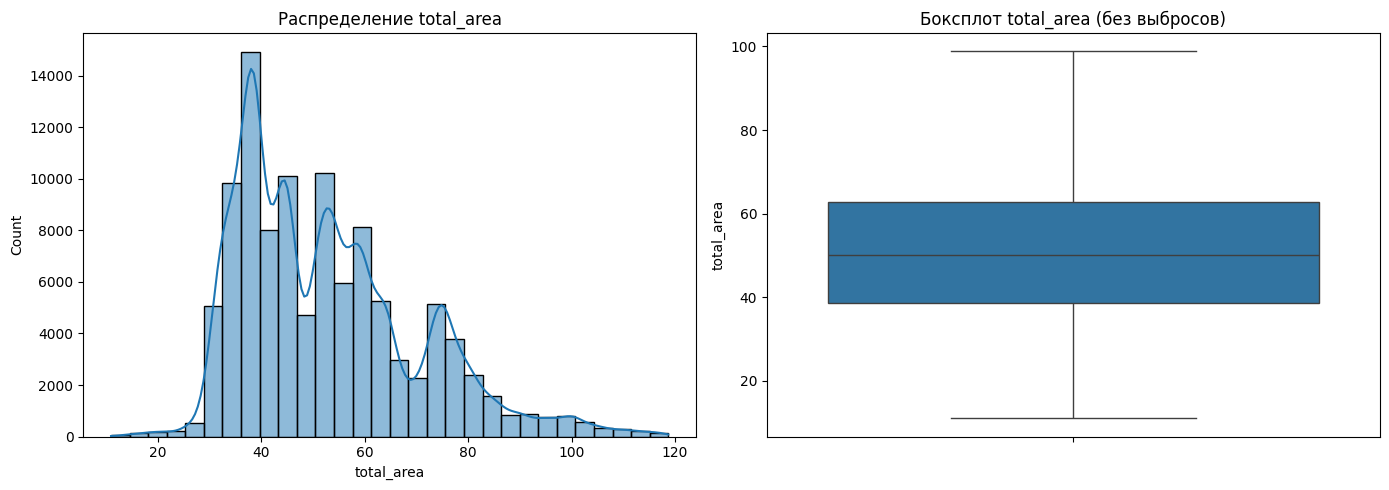

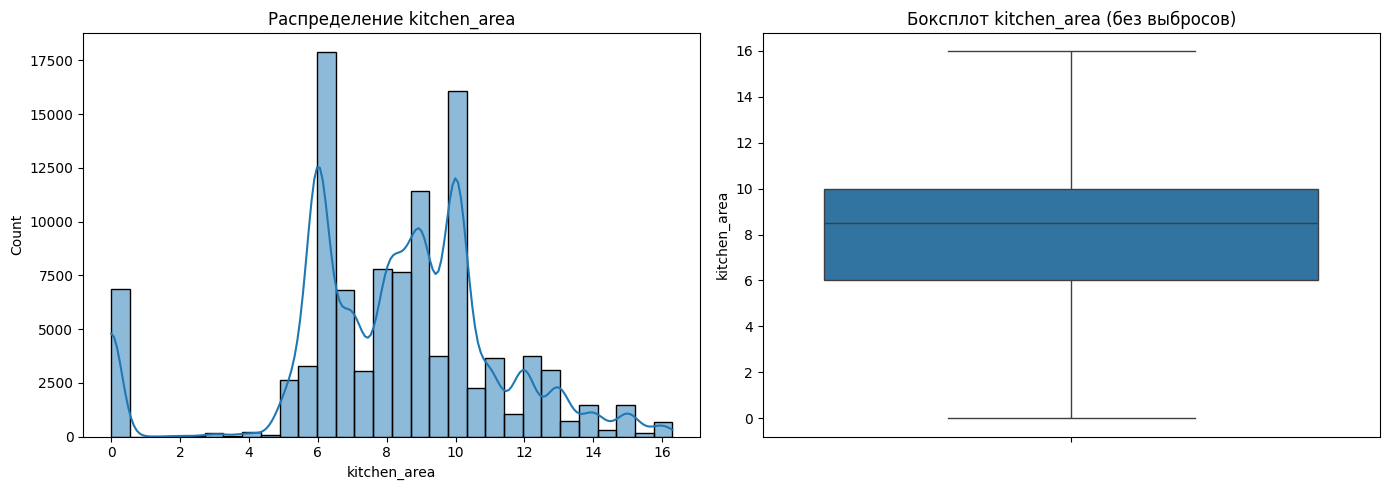

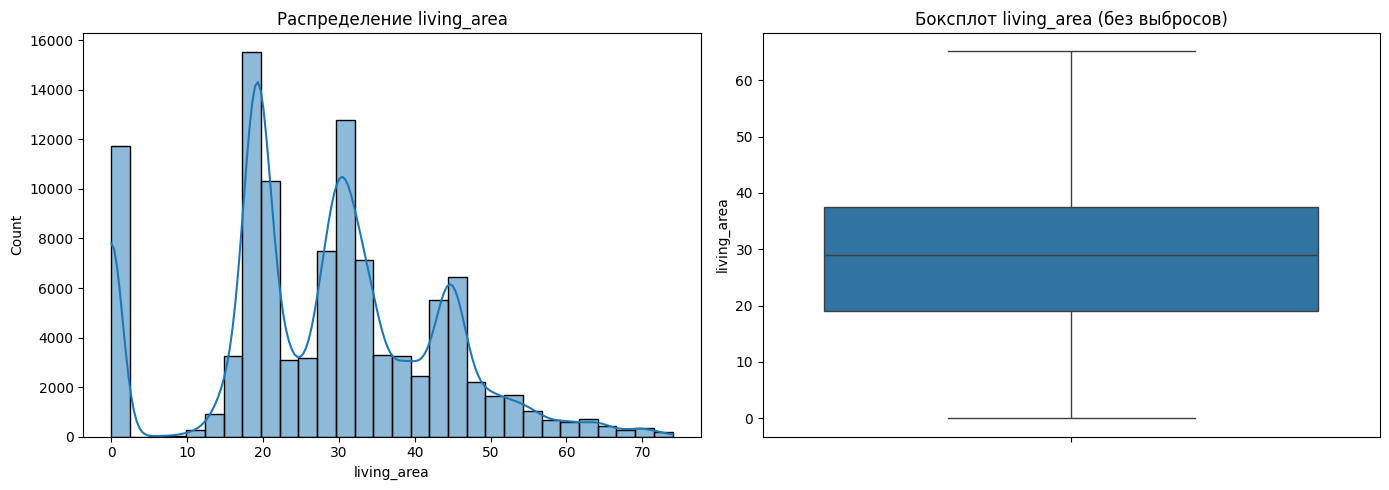

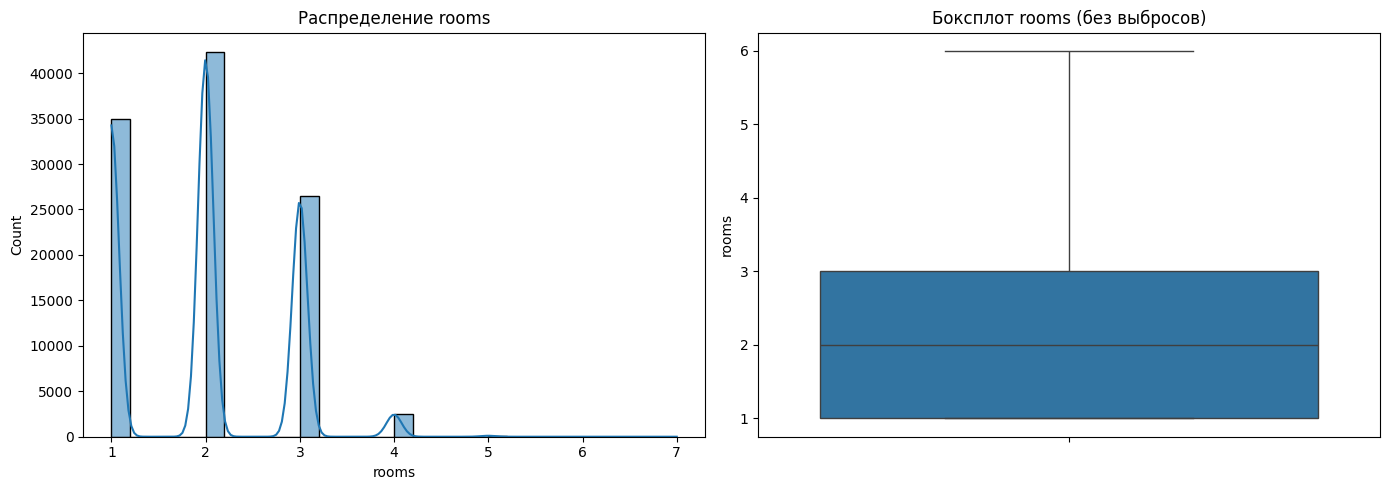

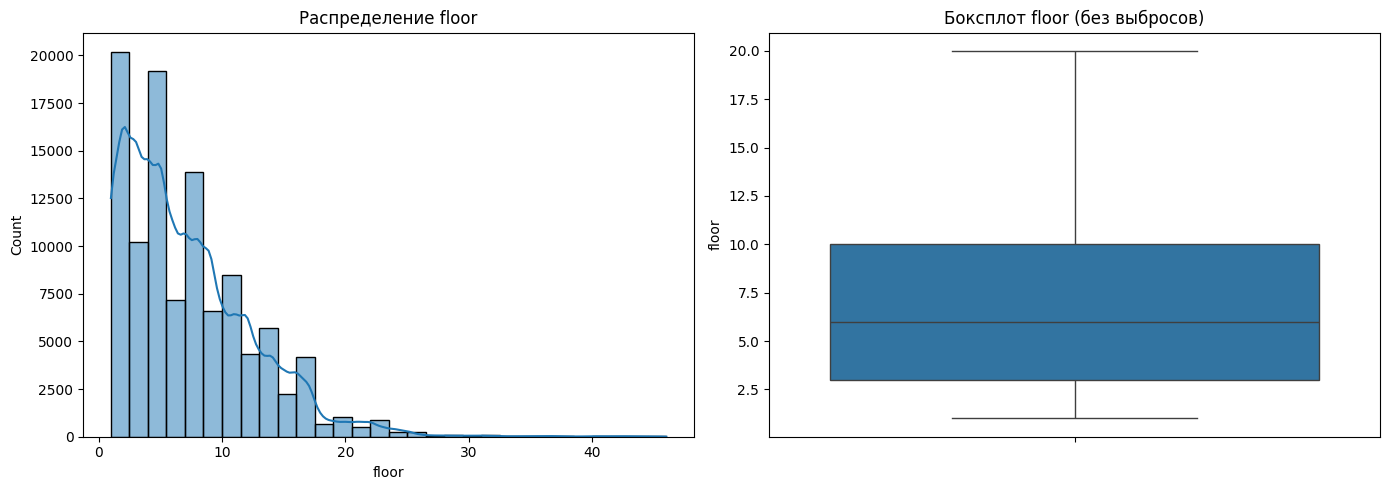

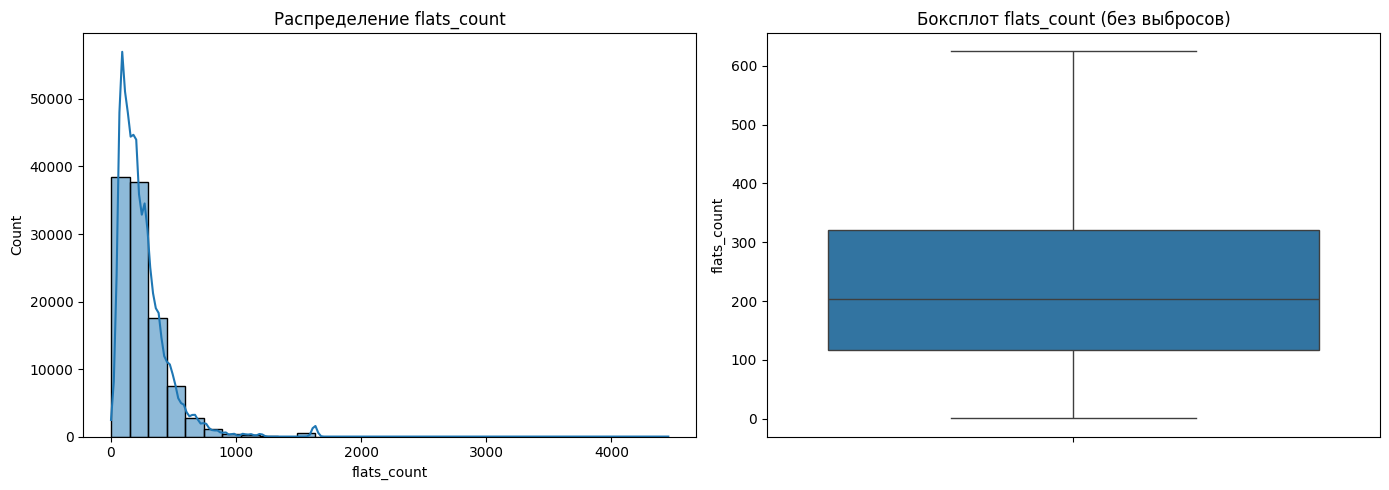

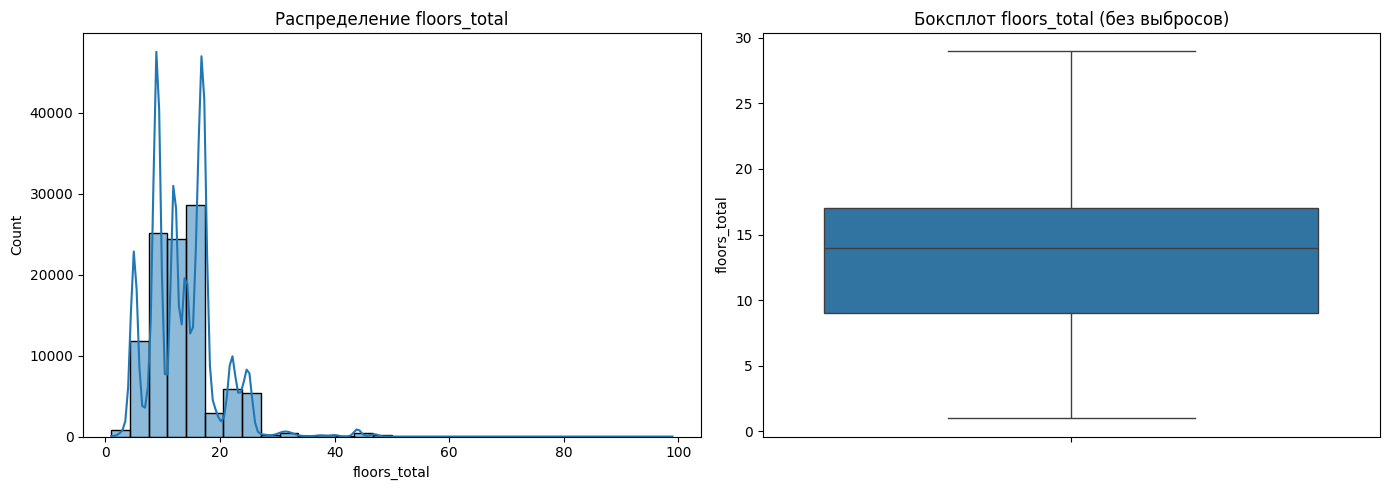

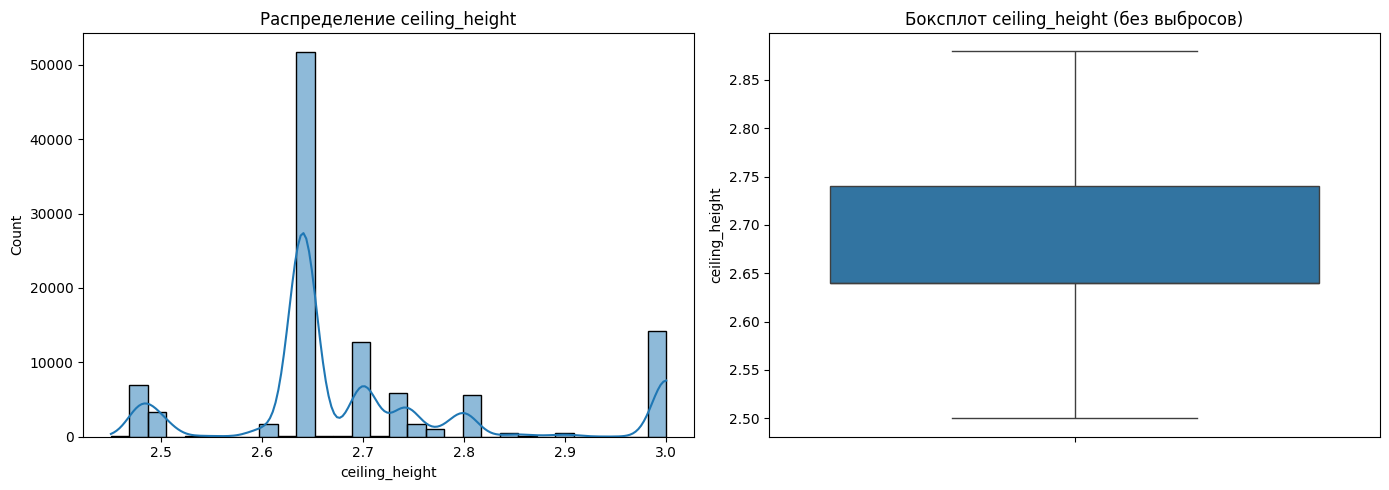

In [14]:
# Численные переменные
num_cols = ['total_area', 'kitchen_area', 'living_area', 'rooms', 'floor', 'flats_count', 'floors_total', 'ceiling_height']

for col in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Гистограмма с KDE
    sns.histplot(df[col], bins=30, kde=True, ax=ax[0])
    ax[0].set_title(f'Распределение {col}')
    
    # Боксплот без выбросов
    sns.boxplot(y=df[col], showfliers=False, ax=ax[1])
    ax[1].set_title(f'Боксплот {col} (без выбросов)')
    
    plt.tight_layout()
    plt.show()

##### Видим, что для признаков living_area и kitchen_area подозрительно много 0. Возможно стоит подумать о замене 0 значение на какое-то медианное, например по количеству комнат или по общей площади.

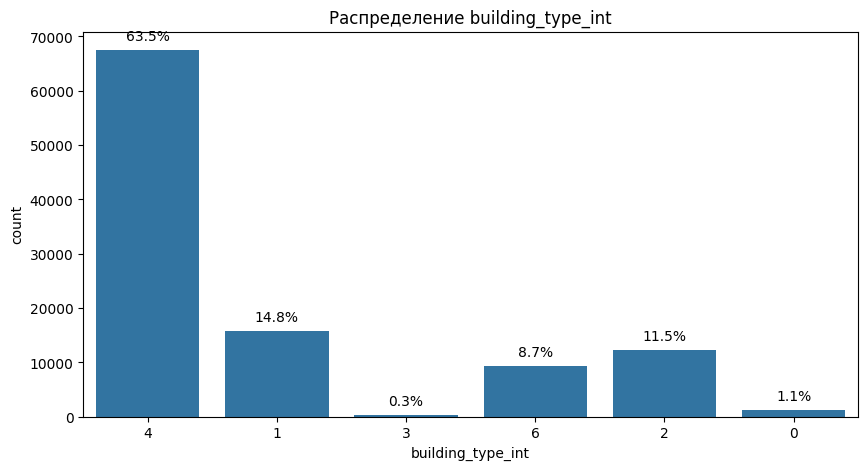

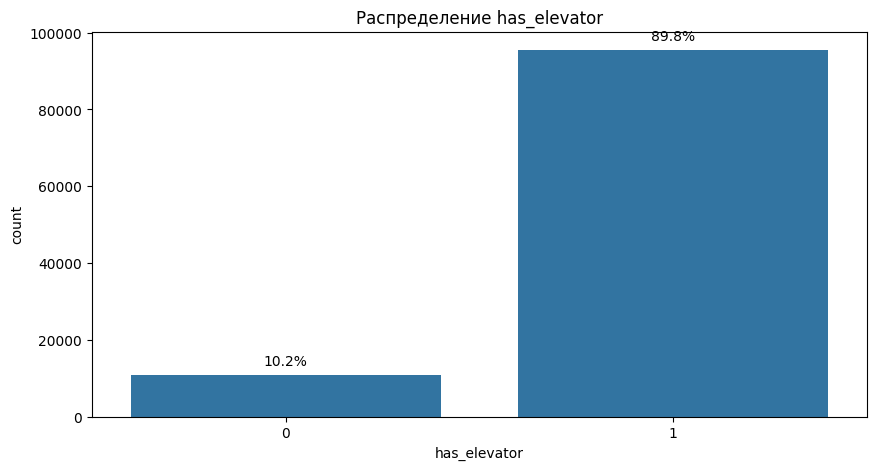

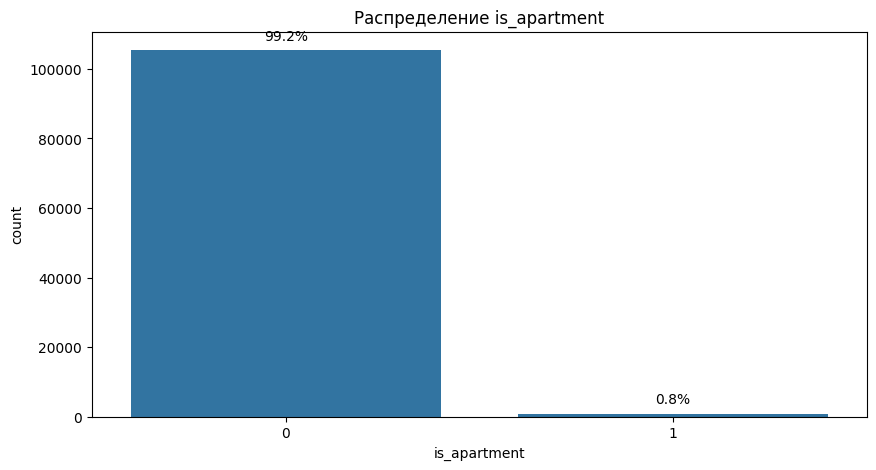

In [15]:
cat_cols = ['building_type_int', 'has_elevator', 'is_apartment']

for col in cat_cols:
    plt.figure(figsize=(10, 5))
    
    # Столбчатая диаграмма с аннотациями
    ax = sns.countplot(x=col, data=df)
    plt.title(f'Распределение {col}')
    
    # Добавляем проценты
    total = len(df)
    for p in ax.patches:
        percentage = f'{100 * p.get_height()/total:.1f}%'
        ax.annotate(percentage, 
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='center', 
                   xytext=(0, 10), 
                   textcoords='offset points')
    
    plt.show()

In [16]:
# 2.4 Анализ целевой переменной

In [19]:
df['price'].quantile([0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 0.999])

0.010     5150000.0
0.100     7150000.0
0.300     9100000.0
0.500    11000000.0
0.700    13650000.0
0.900    19500000.0
0.950    24499000.0
0.990    38000000.0
0.999    76105183.2
Name: price, dtype: float64

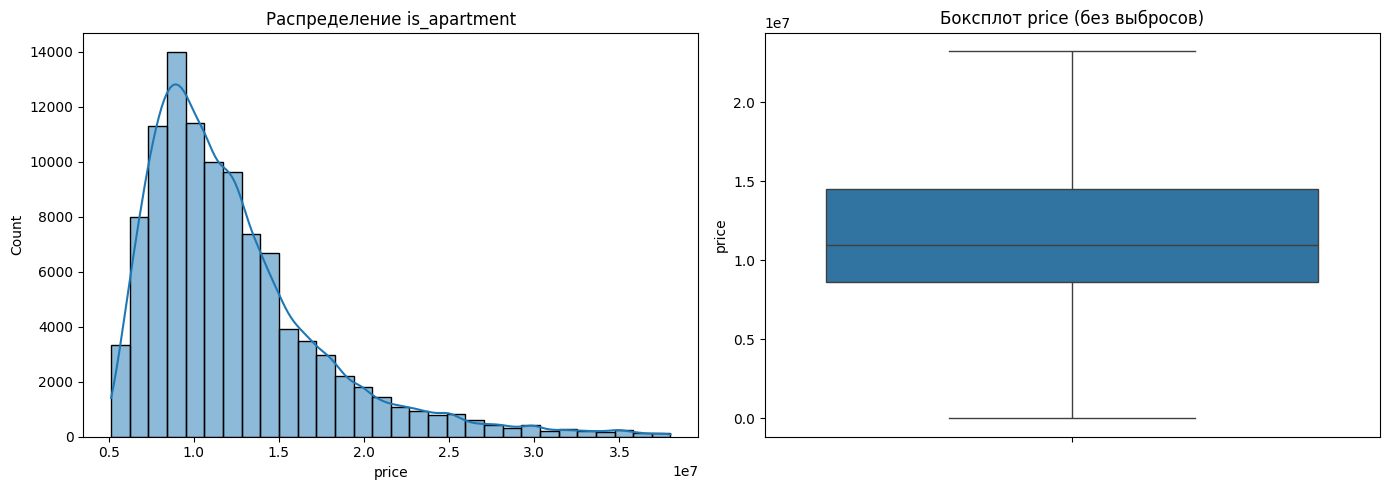

In [20]:
# 2.4 Анализ целевой переменной

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
# Гистограмма с KDE (для наглядности уберем, в соответствии с распределением, самые экстремальные значения)

q_01 = df['price'].quantile(0.01)
q_99 = df['price'].quantile(0.99)

sns.histplot(df[df['price'].between(q_01, q_99)]['price'], bins=30, kde=True, ax=ax[0])
ax[0].set_title(f'Распределение {col}')
    
sns.boxplot(y=df['price'], showfliers=False, ax=ax[1])
ax[1].set_title(f'Боксплот price (без выбросов)')
    
plt.tight_layout()
plt.show()

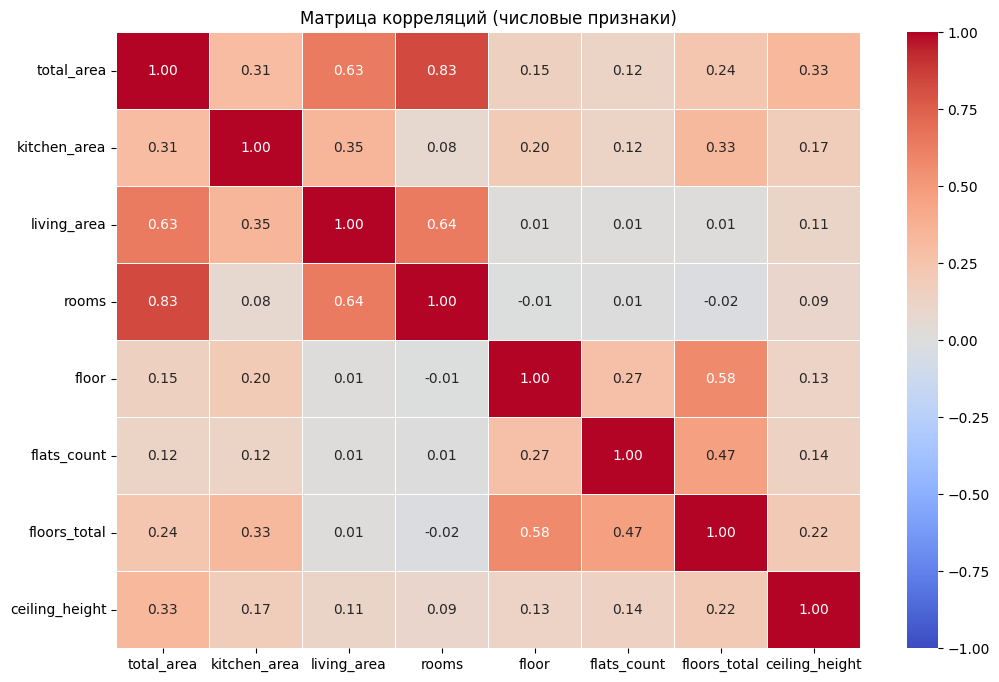

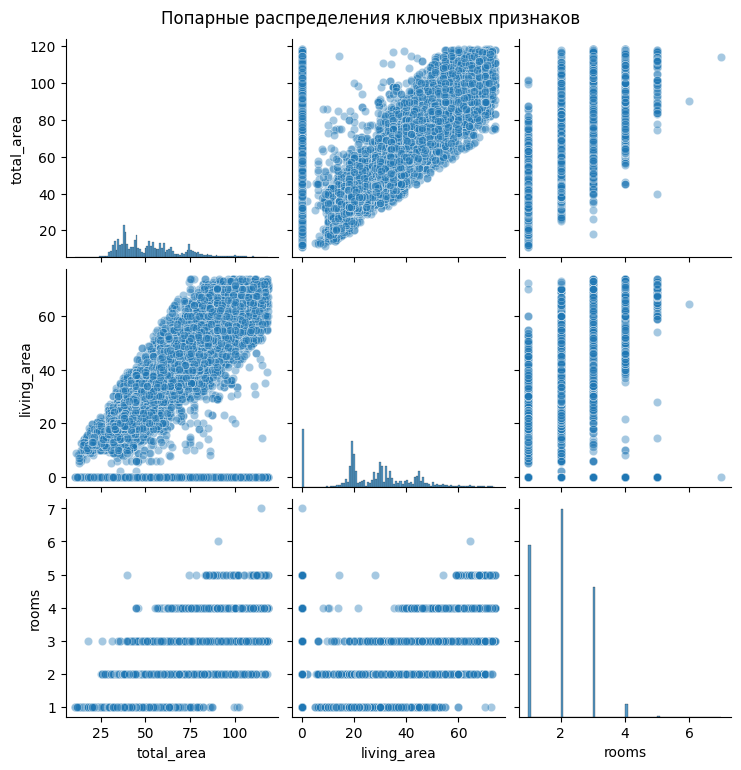

In [21]:
# 2.5 Анализ целевой переменной в зависимости от различных признаков

# Матрица корреляций с аннотациями
num_cols = ['total_area', 'kitchen_area', 'living_area', 'rooms', 'floor', 'flats_count', 'floors_total', 'ceiling_height']

plt.figure(figsize=(12, 8))
corr_matrix = df[num_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
           # mask=mask,
           annot=True, 
           fmt=".2f",
           cmap="coolwarm",
           vmin=-1, vmax=1,
           linewidths=.5)
plt.title('Матрица корреляций (числовые признаки)')
plt.show()

# Точечные графики для ключевых пар
sns.pairplot(df[['total_area', 'living_area', 'rooms']],
             plot_kws={'alpha': 0.4})
plt.suptitle('Попарные распределения ключевых признаков', y=1.02)
plt.show()

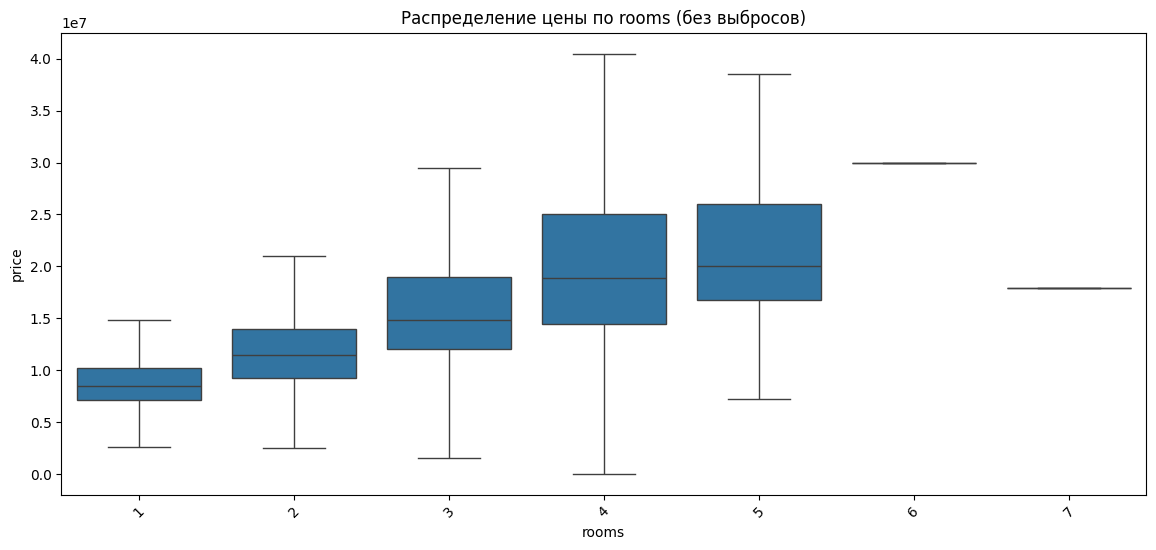

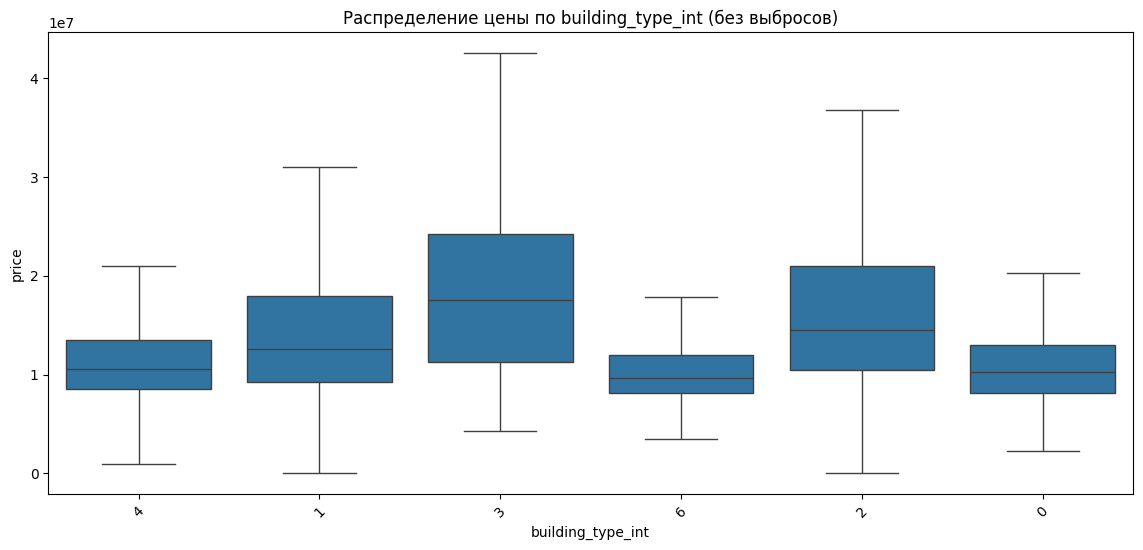

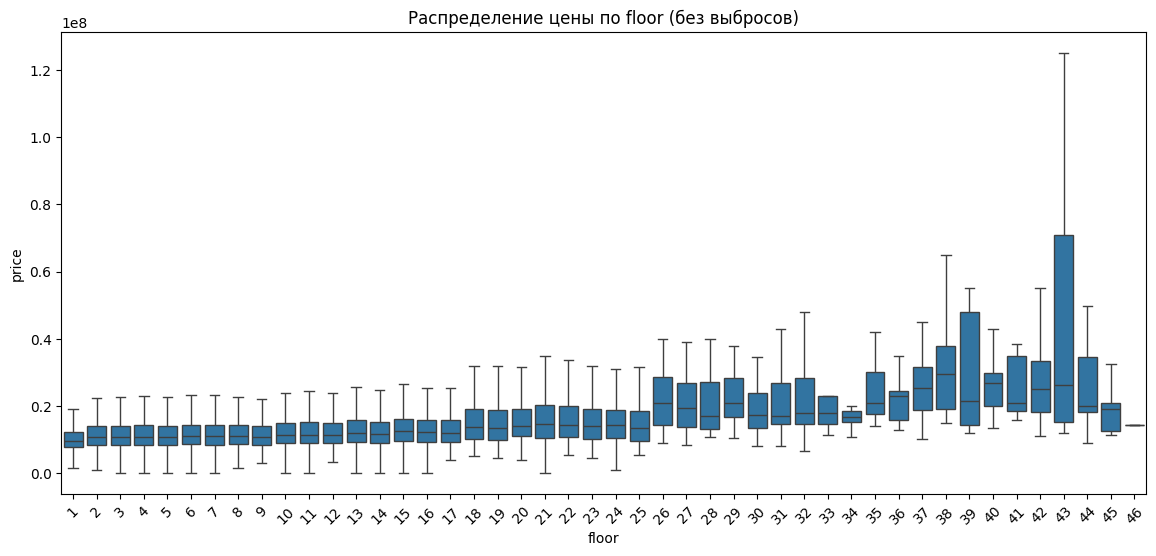

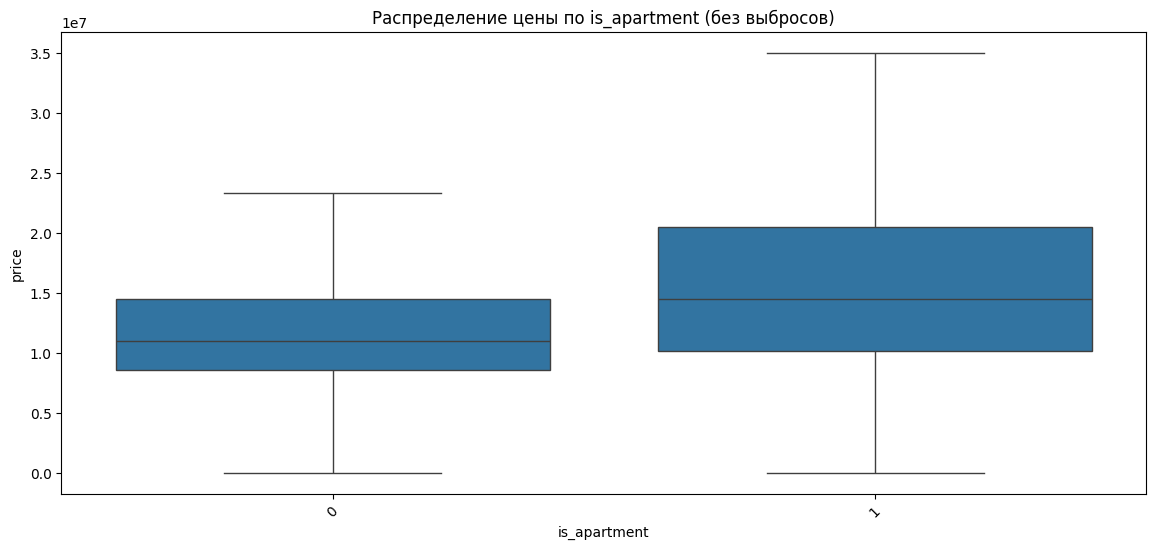

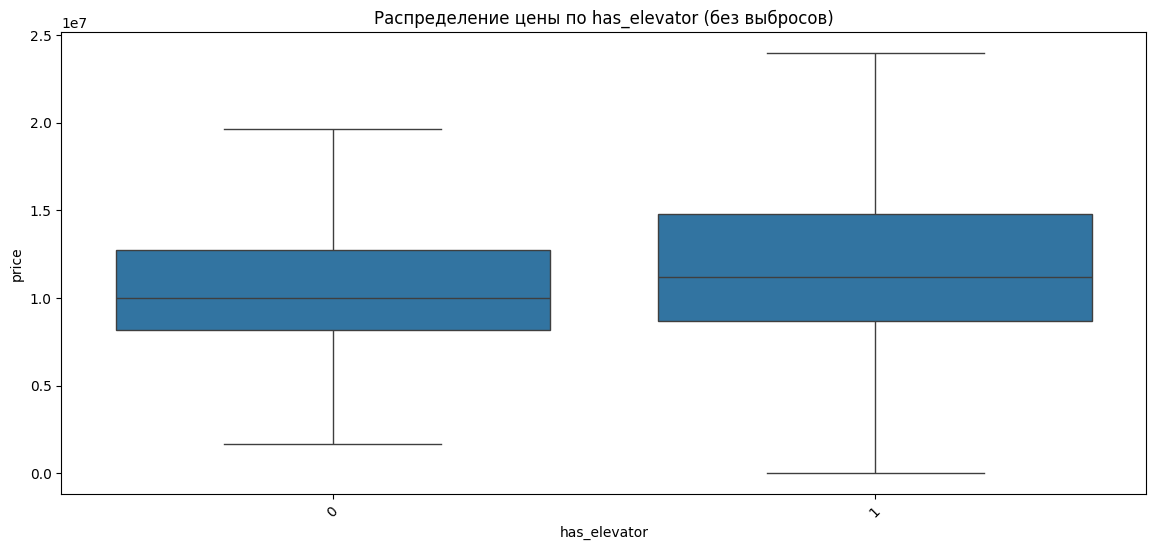

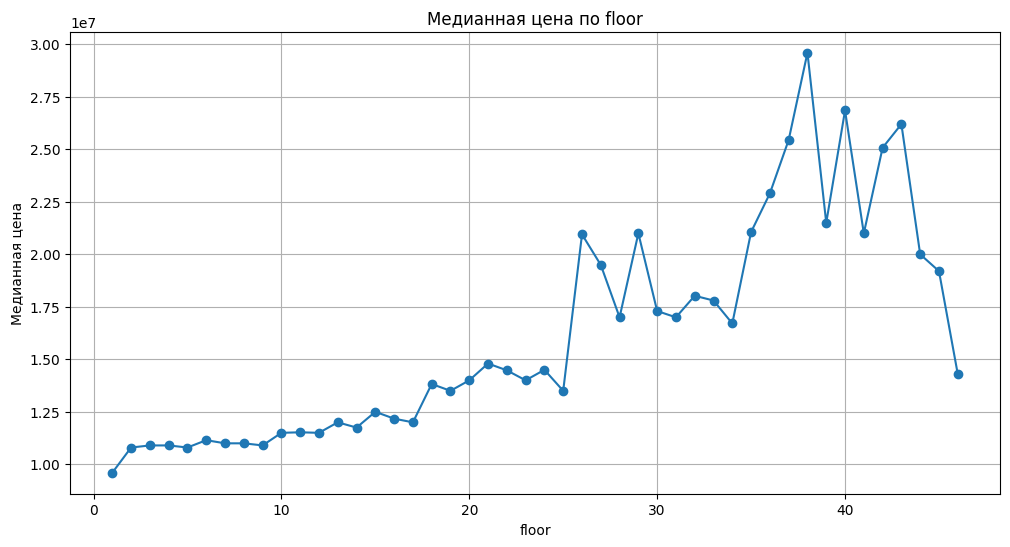

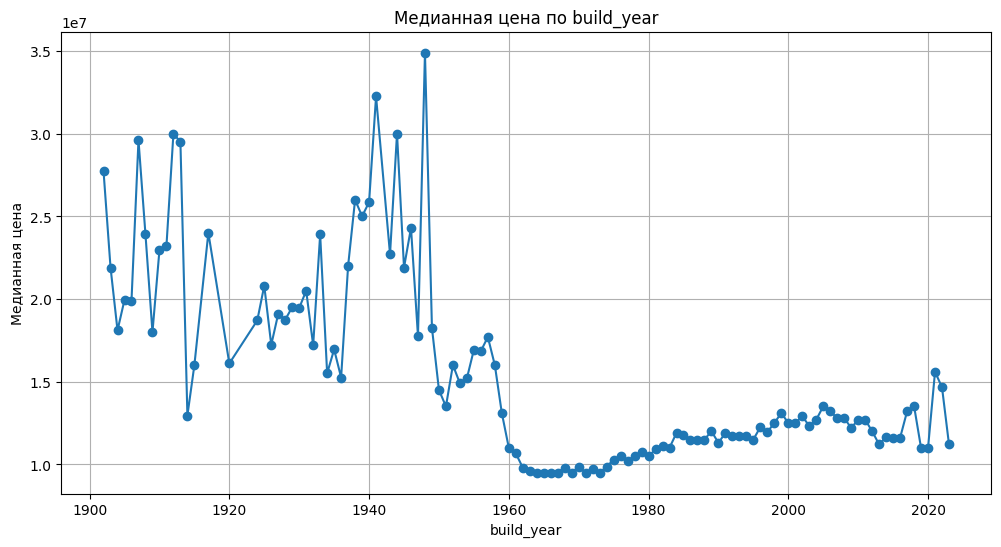

In [22]:
# Анализ цены по категориям

for col in ['rooms', 'building_type_int', 'floor', 'is_apartment', 'has_elevator']:

    plt.figure(figsize=(14, 6))
    sns.boxplot(x=col, 
            y='price', 
            data=df,
            showfliers=False)
    plt.xticks(rotation=45)
    plt.title(f'Распределение цены по {col} (без выбросов)')
    plt.show()

# Анализ динамики по годам

for col in ['floor', 'build_year']:

    df[col] = pd.to_numeric(df[col], errors='coerce')
    yearly_stats = df.groupby(col)['price'].median()
    
    plt.figure(figsize=(12, 6))
    yearly_stats.plot(kind='line', marker='o')
    plt.title(f'Медианная цена по {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Медианная цена')
    plt.grid(True)
    plt.show()

### 2.6 Выводы после EDA

1. Видим, что объем данных довольно большой (100к строк) и этого явно должно хватить для обучения и валидации модели.
2. В данных отсутствуют пропуски, что также положительно влияет на качество моделирования. Хотя возможно, нулевые значения таких признаков как total_area и living_area стоит заменить на медианные по какой-то группе.
3. Хотя в целевой переменной присутствуют выбросы, сам характер распределения логнормальный, что в целом довольно логично. 
4. Явных корреляций с целевой переменной у признаков нет, хотя наблюдаются прямые зависимости с такими переменными как кол-во комнат, этаж, площадь и год постройки(начиная с 1960).

In [24]:
# 2.6 логирование артефактов в MLflow

# поднимаем MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

# название тестового эксперимента и запуска (run) внутри него
EXPERIMENT_NAME = f"EDA_mmakarov_2_sprint"
RUN_NAME = "EDA_run"

# устанавливаем host, который будет отслеживать наши эксперименты
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [25]:
#  Функция нужна для конвертации типов данных
def convert_dtypes(obj):
    if isinstance(obj, np.dtype):
        return str(obj)
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

with open("metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=4, default=convert_dtypes)

In [26]:
#  Функция нужна для конвертации типов данных
def convert_dtypes(obj):
    if isinstance(obj, np.dtype):
        return str(obj)
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

def convert_numpy_types(obj):
    if isinstance(obj, (np.int64, np.int32, np.int16)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32, np.float16)):
        return float(obj)
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

with open("metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=4, default=convert_dtypes)

with open("stats.json", "w", encoding="utf-8") as f:
    json.dump(stats, f, indent=4, default=convert_numpy_types)
    
df.to_csv("dataset.csv", index=False)

In [27]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id
    
# Начинаем логирование, передавая experiment_id
with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME) as run:

    run_id = run.info.run_id  # Получаем уникальный ID запуска
    
    # Логируем метрики
    mlflow.log_metrics(stats)

    # Логируем файлы как артефакты эксперимента, передавая абсолютный путь
    mlflow.log_artifact("stats.json", artifact_path="data")
    mlflow.log_artifact("dataset.csv", artifact_path="data")
        # Логируем файлы как артефакты эксперимента, передавая абсолютный путь
    mlflow.log_artifact("Conclusion_EDA.md", artifact_path="data")
    mlflow.log_artifact("project_template_sprint_2.ipynb", artifact_path="Notebooks")
    

# Получаем информацию о запуске
run = mlflow.get_run(run_id)

# Проверяем статус завершённого эксперимента
assert run.info.status == "FINISHED"

# Удаляем файлы после логирования
os.remove("stats.json")
os.remove("dataset.csv")

#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели
После тщательного исследовательского анализа данных (EDA), вы, скорее всего, сформировали несколько гипотез относительно новых признаков, которые могут улучшить качество вашей модели. На этом этапе, мы предлагаем вам приступить к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используйте ваше понимание данных и результаты EDA для создания новых признаков.
Автоматическая генерация признаков: Воспользуйтесь библиотеками для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.
Важно: Для признаков, созданных вручную, рекомендуется использовать объекты sklearn, такие как Pipeline и ColumnTransformer. Это позволит автоматизировать процесс преобразования данных и облегчить поддержку вашего проекта.

После генерации новых признаков, наступает время обучить новую версию вашей модели, используя эти признаки. Не забудьте залогировать все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

Рекомендуемые шаги:

- Определение и генерация новых признаков на основе ваших гипотез.
- Использование библиотек для автоматической генерации признаков, если это применимо.
- Интеграция новых признаков в вашу модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.

Этот этап проекта критически важен для повышения точности и эффективности вашей модели. Тщательная работа на этом этапе может существенно повлиять на итоговое качество моделирования.


In [28]:
# 3.1 ручная генерация признаков

# Плотность квартир на этаже (flats_per_floor)
df['flats_per_floor'] = df['flats_count'] / df['floors_total']  

# Отношение жилой площади к общей (living_to_total_ratio)
df['living_to_total_ratio'] = df['living_area'] / df['total_area']

# Отношение кухни к общей площади (kitchen_to_total_ratio)
df['kitchen_to_total_ratio'] = df['kitchen_area'] / df['total_area']  

# Этажность квартиры относительно здания (floor_to_total_ratio)
df['floor_to_total_ratio'] = df['floor'] / df['floors_total']  

# Средняя площадь комнаты (avg_room_area)
df['avg_room_area'] = df['total_area'] / df['rooms']  

# Признак "Последний этаж" 
df['is_last_floor'] = (df['floor'] == df['floors_total']).astype(int)  


In [29]:
### Сделаем разбиение на train, test, val
train, temp = train_test_split(df, test_size=0.2)
val, test = train_test_split(temp, test_size=0.5)

train_y = train['price']
val_y = val['price']
test_y = test['price']

# Удаляем временный столбец
train = train.drop(columns=['price']).reset_index(drop=True)
val = val.drop(columns=['price']).reset_index(drop=True)
test = test.drop(columns=['price']).reset_index(drop=True)

print('train.shape - ', train.shape, train_y.mean())
print('val.shape - ', val.shape, val_y.mean())
print('test.shape - ', test.shape, test_y.mean())

###  Видим, что объемы выборок у нас достаточные для построения и валидации модели. 
###  Целевая переменная в выборках также распределена достаточно равномерно.

train.shape -  (85072, 22) 12990690.98359037
val.shape -  (10634, 22) 12759034.219766786
test.shape -  (10635, 22) 12730513.13051246


In [30]:
# Чтобы немного сократить пространство признаков, уберем бинарные и дискретные признаки
numeric_features = [
       'kitchen_area', 'living_area', 'total_area', 
       'ceiling_height'
]

categorical_features = [
    "building_id", "build_year", "building_type_int", 
]

In [31]:
# Автоматическая генерация признаков
from autofeat import AutoFeatRegressor

autofeat = AutoFeatRegressor(transformations=('log', 'exp', 'sqrt'), 
                             feateng_steps=2, 
                             n_jobs=-1,  
                             verbose=0)

# Применяем только к числовым признакам
train_autofit = autofeat.fit_transform(train[numeric_features], train_y)
test_autofit = autofeat.transform(test[numeric_features])
val_autofit = autofeat.transform(val[numeric_features])

train_autofit.drop(numeric_features, axis=1, inplace=True)
test_autofit.drop(numeric_features, axis=1, inplace=True)
val_autofit.drop(numeric_features, axis=1, inplace=True)

train = pd.concat([train, train_autofit], axis=1)
test = pd.concat([test, test_autofit], axis=1)
val = pd.concat([val, val_autofit], axis=1)

In [32]:
# 3.2 оборачивание всех преобразований в объекты sklearn

# Параметры
n_knots = 3
degree_spline = 4
n_quantiles = 100
degree = 3
n_bins = 5
encode = 'ordinal'
strategy = 'uniform'
subsample = None


# Препроцессинг для числовых признаков
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler()),
    ('quant', QuantileTransformer(n_quantiles=n_quantiles)),
    ("polynomial", PolynomialFeatures(degree=degree, 
                                      include_bias=False)), 
    ("kbd", KBinsDiscretizer(n_bins=n_bins, 
                             encode=encode, 
                             strategy=strategy, 
                             subsample=subsample))  
])

# Препроцессинг для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", 
                             categories="auto",
                             max_categories=10, 
                             sparse_output=False, 
                             drop="first" ))
])

# Общий ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),  
        ("cat", categorical_transformer, categorical_features), 
    ],
    remainder="passthrough"  # все остальные признаки пропускаем без изменений
)


In [33]:

model_new = CatBoostRegressor(depth=5, iterations=1001, random_state=42)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", model_new)
])

pipeline.fit(train, train_y)

y_pred = pipeline.predict(test)

mae = mean_absolute_error(test_y, y_pred)
mse = mean_squared_error(test_y, y_pred, squared=False)
r2 = r2_score(test_y, y_pred)
mape = mean_absolute_percentage_error(test_y, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {mse:.2f}")
print(f"r2: {r2:.2f}")
print(f"MAPE: {mape:.2f}")

Learning rate set to 0.082553
0:	learn: 48872231.5795040	total: 79.9ms	remaining: 1m 19s
1:	learn: 48842072.3745600	total: 98.9ms	remaining: 49.4s
2:	learn: 48814746.7650241	total: 118ms	remaining: 39.3s
3:	learn: 48786974.7262769	total: 138ms	remaining: 34.5s
4:	learn: 48710800.1498884	total: 159ms	remaining: 31.6s
5:	learn: 48692461.9156389	total: 178ms	remaining: 29.5s
6:	learn: 48647501.8515727	total: 193ms	remaining: 27.5s
7:	learn: 48633379.6742194	total: 212ms	remaining: 26.3s
8:	learn: 48618262.6033361	total: 230ms	remaining: 25.3s
9:	learn: 48605580.3777716	total: 248ms	remaining: 24.6s
10:	learn: 48596334.9353531	total: 266ms	remaining: 23.9s
11:	learn: 48534925.4662602	total: 283ms	remaining: 23.4s
12:	learn: 48494216.2163607	total: 302ms	remaining: 22.9s
13:	learn: 48437745.0870690	total: 316ms	remaining: 22.3s
14:	learn: 48394567.4162712	total: 333ms	remaining: 21.9s
15:	learn: 48113145.2121820	total: 361ms	remaining: 22.2s
16:	learn: 48059941.3953457	total: 377ms	remainin

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE: 2531507.46
RMSE: 10726539.79
r2: -1.60
MAPE: 67.85


/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
# 3.5 логирование артефактов в MLflow

In [35]:
from mlflow.models.signature import infer_signature
from mlflow.pyfunc import PythonModel

import platform
import datetime

In [36]:
# Настройка подключения к tracking и registry
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"

mlflow.set_tracking_uri(f'http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}')

# название тестового эксперимента и запуска (run) внутри него
EXPERIMENT_NAME = f"feature_engineering_mmakarov_2_sprint"
RUN_NAME = "feature_engineering_run"
REGISTRY_MODEL_NAME = "price_prediction"

# Создаём или получаем эксперимент
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id


with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:

    run_id = run.info.run_id

    mlflow.log_params({
        "n_knots": n_knots,
        "degree_spline": degree_spline,
        "n_quantiles": n_quantiles,
        "degree": degree,
        "n_bins": n_bins,
        "encode": encode,
        "strategy": strategy,
        "model_type": "CatBoostRegressor",
        "model_depth": 5,
        "model_iterations": 1001
    })
    
    mlflow.log_metrics({
        "mae": mae,
        "rmse": mse,
        "r2": r2,
        "mape": mape
    })

    # Логируем окружение
    mlflow.log_params({
        "python_version": platform.python_version(),
        "platform": platform.platform(),
        "execution_date": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    })

    # Путь до файла с зависимостями pip
    pip_requirements = "../requirements.txt"

    signature = infer_signature(train, y_pred)
    
    mlflow.sklearn.log_model(
        pipeline,
        artifact_path="models",
        pip_requirements=pip_requirements,
        signature=signature,
        registered_model_name=REGISTRY_MODEL_NAME,
        input_example=train.iloc[:5].to_dict('list')
    )
    

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None
Registered model 'price_prediction' already exists. Creating a new version of this model...
2025/05/04 15:49:52 INFO ml

#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


In [37]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestRegressor

In [38]:
# Получаем имена признаков после препроцессинга
feature_names = preprocessor.get_feature_names_out()

train_preprocessed = preprocessor.fit_transform(train, train_y)

# Преобразуем train в DataFrame с названиями столбцов
train_preprocessed_df = pd.DataFrame(
    train_preprocessed, 
    columns=feature_names
)

print("Все признаки после препроцессинга:", feature_names)

Все признаки после препроцессинга: ['num__kitchen_area' 'num__living_area' 'num__total_area'
 'num__ceiling_height' 'num__kitchen_area^2'
 'num__kitchen_area living_area' 'num__kitchen_area total_area'
 'num__kitchen_area ceiling_height' 'num__living_area^2'
 'num__living_area total_area' 'num__living_area ceiling_height'
 'num__total_area^2' 'num__total_area ceiling_height'
 'num__ceiling_height^2' 'num__kitchen_area^3'
 'num__kitchen_area^2 living_area' 'num__kitchen_area^2 total_area'
 'num__kitchen_area^2 ceiling_height' 'num__kitchen_area living_area^2'
 'num__kitchen_area living_area total_area'
 'num__kitchen_area living_area ceiling_height'
 'num__kitchen_area total_area^2'
 'num__kitchen_area total_area ceiling_height'
 'num__kitchen_area ceiling_height^2' 'num__living_area^3'
 'num__living_area^2 total_area' 'num__living_area^2 ceiling_height'
 'num__living_area total_area^2'
 'num__living_area total_area ceiling_height'
 'num__living_area ceiling_height^2' 'num__total_area^3

In [39]:

estimator = RandomForestRegressor(max_depth=5, n_estimators=10)

sfs = SFS(estimator,
    k_features=30,       
    forward=True,      
    floating=False,     
    scoring='neg_mean_absolute_percentage_error', 
    cv=0,               
    n_jobs=-1
)


In [40]:
sfs = sfs.fit(train_preprocessed, train_y)   

In [41]:
# Получаем индексы отобранных признаков
selected_indices_forward = list(sfs.k_feature_idx_)

# Преобразуем индексы в названия
selected_features_forward = [feature_names[i] for i in selected_indices_forward]

print("Forward Selection выбрал:", selected_features_forward)

Forward Selection выбрал: ['num__kitchen_area', 'num__ceiling_height', 'num__kitchen_area^2', 'num__kitchen_area living_area', 'num__kitchen_area total_area', 'num__kitchen_area ceiling_height', 'num__total_area^2', 'num__kitchen_area^3', 'num__kitchen_area^2 living_area', 'num__kitchen_area^2 total_area', 'num__kitchen_area living_area total_area', 'num__kitchen_area ceiling_height^2', 'num__living_area^3', 'num__living_area^2 ceiling_height', 'num__living_area total_area^2', 'num__living_area total_area ceiling_height', 'num__living_area ceiling_height^2', 'num__ceiling_height^3', 'cat__building_id_23949', 'cat__building_id_23995', 'cat__building_id_24035', 'cat__building_id_24057', 'cat__building_id_24495', 'cat__building_id_infrequent_sklearn', 'cat__build_year_1972', 'cat__build_year_2018', 'cat__build_year_infrequent_sklearn', 'remainder__id', 'remainder__longitude', 'remainder__has_elevator']


In [42]:
sbs = SFS(estimator,
    k_features=10,  # тут поставил немного поменьше значение, так как оч долго работает...
    forward=False,      
    floating=False,     
    scoring='neg_mean_absolute_percentage_error', 
    cv=0,               
    n_jobs=-1
)

sbs = sbs.fit(train_preprocessed, train_y)

In [43]:
selected_indices_backward = list(sbs.k_feature_idx_)
selected_features_backward = [feature_names[i] for i in selected_indices_backward]

print("Backward Elimination выбрал:", selected_features_backward)

Backward Elimination выбрал: ['num__kitchen_area', 'num__total_area', 'num__living_area^2', 'num__kitchen_area total_area ceiling_height', 'num__living_area^2 ceiling_height', 'cat__building_id_24195', 'cat__building_id_24495', 'remainder__is_apartment', 'remainder__longitude', 'remainder__has_elevator']


/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


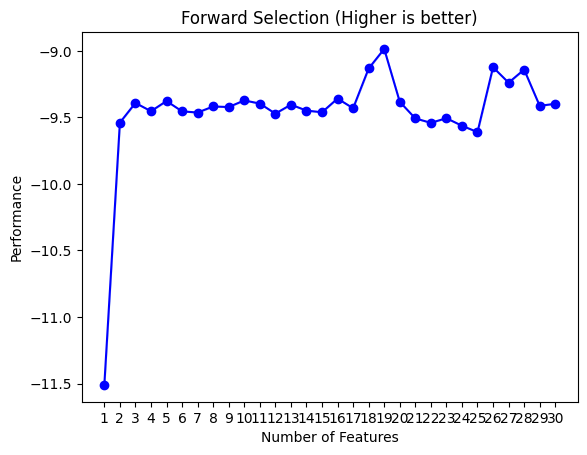

In [45]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection

# Для Forward Selection
fig = plot_sfs(sfs.get_metric_dict(), kind="std_dev")
plt.title("Forward Selection (Higher is better)")
plt.show()

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


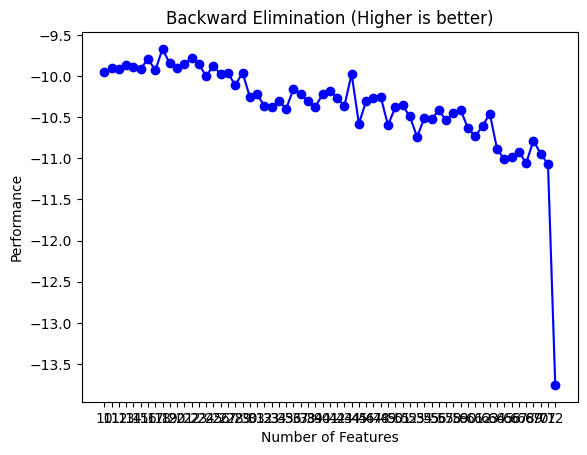

In [46]:
# Для Backward Elimination
fig = plot_sfs(sbs.get_metric_dict(), kind="std_dev")
plt.title("Backward Elimination (Higher is better)")
plt.show()

In [49]:
# Объединение признаков
selected_features = list(set(selected_features_forward + selected_features_backward))

In [53]:
# 4.4 Обучение новой версии модели
# Выбираем только отобранные признаки
X_train_selected = train_preprocessed_df[selected_features]
X_test_selected = pd.DataFrame(
    preprocessor.transform(test), 
    columns=feature_names
)[selected_features]

# Обучаем CatBoost на отобранных фичах
model_selected = CatBoostRegressor(depth=5, iterations=1001)
model_selected.fit(X_train_selected, train_y)

# Оценка на тесте
y_pred = model_selected.predict(X_test_selected)

mae = mean_absolute_error(test_y, y_pred)
mse = mean_squared_error(test_y, y_pred, squared=False)
r2 = r2_score(test_y, y_pred)
mape = mean_absolute_percentage_error(test_y, y_pred)

print(f"MAE после отбора признаков: {mae:.2f}")
print(f"RMSE после отбора признаков: {mse:.2f}")
print(f"r2 после отбора признаков: {r2:.2f}")
print(f"MAPE после отбора признаков: {mape:.2f}")

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Learning rate set to 0.082553
0:	learn: 48871900.6370231	total: 47.6ms	remaining: 47.6s
1:	learn: 48842395.6456618	total: 80.1ms	remaining: 40s
2:	learn: 48806330.5872112	total: 104ms	remaining: 34.6s
3:	learn: 48779580.9226992	total: 132ms	remaining: 32.9s
4:	learn: 48751536.0398021	total: 153ms	remaining: 30.5s
5:	learn: 48732052.5580359	total: 173ms	remaining: 28.7s
6:	learn: 48715541.1297862	total: 186ms	remaining: 26.4s
7:	learn: 48702077.4129608	total: 200ms	remaining: 24.8s
8:	learn: 48691041.5303568	total: 214ms	remaining: 23.6s
9:	learn: 48626310.2424109	total: 229ms	remaining: 22.7s
10:	learn: 48616035.7323783	total: 242ms	remaining: 21.8s
11:	learn: 48608583.5096730	total: 256ms	remaining: 21.1s
12:	learn: 48549650.2822984	total: 267ms	remaining: 20.3s
13:	learn: 48491896.6430712	total: 278ms	remaining: 19.6s
14:	learn: 48486270.5074550	total: 290ms	remaining: 19s
15:	learn: 48479788.1053896	total: 301ms	remaining: 18.6s
16:	learn: 48474525.2789911	total: 314ms	remaining: 18

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Registered model 'price_prediction' already exists. Creating a new version of this model...
2025/05/04 18:11:38 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: price_prediction, version 8
Created version '8' of model 'price_prediction'.
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype

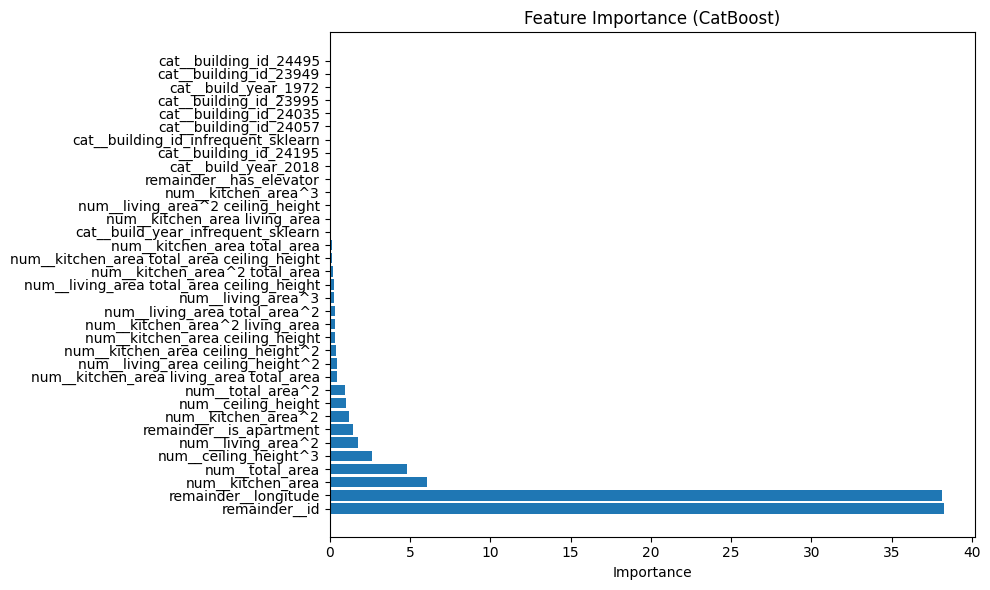

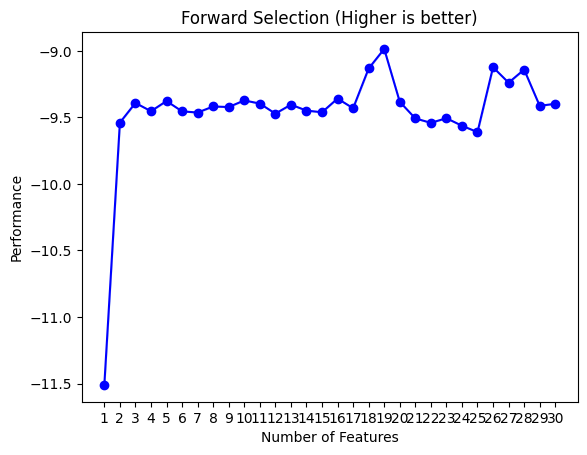

In [57]:
# 4.5 Логирование всех артефактов в MLflow

# Настройка подключения к tracking и registry
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"

mlflow.set_tracking_uri(f'http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}')

# название тестового эксперимента и запуска (run) внутри него
EXPERIMENT_NAME = f"feature_selection_mmakarov_2_sprint"
RUN_NAME = "feature_selection_run"
REGISTRY_MODEL_NAME = "price_prediction"

# Создаём или получаем эксперимент
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id


with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:

    run_id = run.info.run_id

    # Логируем параметры
    mlflow.log_params({
        "model": "CatBoostRegressor",
        "depth": 5,
        "iterations": 1001,
        "feature_selection": ["Forward Selection", "Backward Elimination"]
    })

    # Логируем отобранные фичи
    mlflow.log_dict({"features": selected_features_forward}, "features.json")

    # Логируем метрики
    mlflow.log_metrics({
         "mae": mae,
        "rmse": mse,
        "r2": r2,
        "mape": mape
    })
    
    signature = infer_signature(X_test_selected, y_pred)

    # Логируем модель
    mlflow.sklearn.log_model(model_selected, 
        artifact_path="models",
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=X_train_selected.iloc[:5].to_dict('list'),
        registered_model_name=REGISTRY_MODEL_NAME)
    
    # Данные для графика
    feature_importance = pd.DataFrame({
        "feature": selected_features,
        "importance": model_selected.feature_importances_
    }).sort_values("importance", ascending=False)
    
    # Сохраняем в CSV
    feature_importance.to_csv("feature_importance.csv", index=False)
    mlflow.log_artifact("feature_importance.csv")
    
    # Создаем и сохраняем графики
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance["feature"], feature_importance["importance"])
    plt.title("Feature Importance (CatBoost)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    mlflow.log_artifact("feature_importance.png")

    # Для Forward Selection
    fig = plot_sfs(sfs.get_metric_dict(), kind="std_dev")
    plt.title("Forward Selection (Higher is better)")
    plt.savefig("forward_selection.png")
    mlflow.log_artifact("forward_selection.png")

    # Для Backward Selection
    fig = plot_sfs(sbs.get_metric_dict(), kind="std_dev")
    plt.title("Backward Elimination (Higher is better)")
    plt.savefig("Backward Elimination.png")
    mlflow.log_artifact("Backward Elimination.png")

    plt.close()

### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

In [58]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1

import optuna
from optuna.integration.mlflow import MLflowCallback

from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID
from statistics import median
from sklearn.model_selection import KFold

In [59]:
# Инициализация MLflow
EXPERIMENT_NAME = "find_params_price_prediction"  # имя эксперимента
RUN_NAME = "model_bayesian_search"  # имя запуска

# Настройка базы данных для Optuna
STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "price_prediction_model"

In [61]:
# Функция objective для Optuna
def objective(trial: optuna.Trial) -> float:
    # Сетка гиперпараметров
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 5),
        "random_strength": trial.suggest_float("random_strength", 0.1, 5),
        "loss_function": "RMSE",
        "task_type": "CPU",
        "random_seed": 0,
        "iterations": 300,
        "verbose": False,
    }

    # Создаём модель CatBoostClassifier
    model = CatBoostRegressor(**param)

    # Кросс-валидация
    skf = StratifiedKFold(n_splits=5)
    metrics = defaultdict(list)

    for train_index, val_index in skf.split(X_train_selected, train_y):
        # Разделение данных на тренировочную и валидационную выборки
        train_x = X_train_selected.iloc[train_index]
        val_x = X_train_selected.iloc[val_index]

        tr_y = train_y.iloc[train_index]
        val_y = train_y.iloc[val_index]

        # Обучение модели
        model.fit(train_x, tr_y, verbose=False)

        # Предсказание
        prediction = model.predict(val_x)

        # Вычисление метрик
        mae = mean_absolute_error(val_y, prediction)
        mse = mean_squared_error(val_y, prediction, squared=False)
        r2 = r2_score(val_y, prediction)
        mape = mean_absolute_percentage_error(val_y, prediction)

        # Сохранение метрик
        metrics["mae"].append(mae)
        metrics["mse"].append(mse)
        metrics["r2"].append(r2)
        metrics["mape"].append(mape)

        # Агрегирование метрик (среднее значение)
    mae = np.mean(metrics["mae"])
    mse = np.mean(metrics["mse"])
    r2 = np.mean(metrics["r2"])
    mape = np.mean(metrics["mape"])

    # Логирование метрик в MLflow
    mlflow.log_metrics(
        {
            "mae": mae,
            "mse": mse,
            "r2": r2,
            "mape": mape,
        }
    )

    return mse  # Возвращаем mse для оптимизации

In [62]:
if mlflow.active_run():
    mlflow.end_run()

# Создание эксперимента в MLflow
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

# Запуск MLflow
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    # MLflow Callback
    mlflc = MLflowCallback(
        tracking_uri=f'http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}',  # URI для MLflow
        metric_name='RMSE', 
        create_experiment=False, 
        mlflow_kwargs={'experiment_id': experiment_id, 
                       'nested': True,
                       'tags': {'MLFLOW_PARENT_RUN_ID': run_id}})

    # Создание study с TPE Sampler
    sampler = TPESampler(seed=42)  # используем TPE алгоритм для выбора гиперпараметров
    study = optuna.create_study(
        study_name=STUDY_NAME,
        storage=STUDY_DB_NAME,
        sampler=optuna.samplers.TPESampler(),
        direction="minimize",  #  Минимизируем MSE
        load_if_exists=True,  # загружаем существующее study, если оно есть
    )

    # Оптимизация
    study.optimize(objective, n_trials=10, callbacks=[mlflc])

    # Лучшие параметры
    best_params = study.best_params

    # Логирование лучших параметров
    mlflow.log_params(best_params)
    model = CatBoostRegressor(**best_params)

    model.fit(X_train_selected, train_y, verbose=False)

    # Предсказание
    prediction = model.predict(X_test_selected)

    # Вычисление метрик
    mae = mean_absolute_error(test_y, prediction)
    mse = mean_squared_error(test_y, prediction, squared=False)
    r2 = r2_score(test_y, prediction)
    mape = mean_absolute_percentage_error(test_y, prediction)

    print('MAE - ', mae)
    print('MSE - ', mse)
    print('R2 - ', r2)
    print('MAPE- ', mape)
    
    signature = infer_signature(X_test_selected, prediction)

    # Логирование лучшей модели в MLflow
    mlflow.sklearn.log_model(model, 
                             artifact_path="cv", 
                             pip_requirements=pip_requirements,
                             signature=signature,
                             input_example=X_train_selected.iloc[:5].to_dict('list'),
                             registered_model_name="Model_best_params_optuna")
    
    # Вывод результатов
    print(f"Number of finished trials: {len(study.trials)}")
    print(f"Best params: {best_params}")

/tmp/ipykernel_4562/1098547929.py:16: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(
[I 2025-05-04 18:13:27,483] Using an existing study with name 'price_prediction_model' instead of creating a new one.
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/sklearn/metr

MAE -  2683232.4207338896
MSE -  13601882.359873008
R2 -  -3.181147330879308
MAPE-  71.09346486093162


Successfully registered model 'Model_best_params_optuna'.
2025/05/04 18:23:37 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Model_best_params_optuna, version 1


Number of finished trials: 28
Best params: {'learning_rate': 0.06525804408920957, 'depth': 11, 'l2_leaf_reg': 0.6954865917311157, 'random_strength': 3.031789948182692}


Created version '1' of model 'Model_best_params_optuna'.


In [64]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2

In [65]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [68]:
EXPERIMENT_NAME = 'find_params_RS'# ваш код здесь
RUN_NAME = 'find_params_RS' # ваш код здесь
REGISTRY_MODEL_NAME = 'price_prediction'# ваш код здесь

features = selected_features_forward
target = "price"

# split_column = "monthly_charges"
stratify_column = 'price'
test_size = 2000

# df = df.sort_values(by=[split_column])

# X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], 
#                                                    test_size=test_size, 
#                                                    shuffle=False)

print(f"Размер выборки для обучения: {X_train_selected.shape}")
print(f"Размер выборки для теста: {X_test_selected.shape}")

loss_function = "RMSE"
task_type = 'CPU'
random_seed = 0
iterations = 300
verbose = False

params = {
    'depth': [3, 4, 5, 6, 7],
    'learning_rate': np.logspace(-3, -1, 5),
    'iterations': [200, 300, 400],
    'l2_leaf_reg': np.logspace(-2, 0, 3)
} 

model = CatBoostRegressor(verbose=verbose, 
                           loss_function=loss_function, 
                           random_seed=random_seed, 
                           task_type=task_type, 
                           iterations=iterations)# ваш код здесь

cv = RandomizedSearchCV(cv=5, 
                        n_jobs=-1, n_iter=20, 
                        param_distributions=params, 
                        estimator=model)

clf = cv.fit(X_train_selected, train_y) 

cv_results = pd.DataFrame(clf.cv_results_)
best_params = clf.best_params_

model = CatBoostRegressor(**best_params, 
                           verbose=verbose, 
                           loss_function=loss_function, 
                           random_seed=random_seed, 
                           task_type=task_type)

model.fit(X_train_selected, train_y)

prediction = model.predict(X_test_selected)

# расчёт метрик качества
metrics = {}

    # Вычисление метрик
mae = mean_absolute_error(test_y, prediction)
mse = mean_squared_error(test_y, prediction, squared=False)
r2 = r2_score(test_y, prediction)
mape = mean_absolute_percentage_error(test_y, prediction)


# сохранение метрик в словарь
metrics["mae"] = mae
metrics["mse"] = mse
metrics["r2"] = r2
metrics["mape"] = mape


# дополнительные метрики из результатов кросс-валидации
metrics['mean_fit_time'] = cv_results['mean_fit_time'].mean()# среднее время обучения
metrics['std_fit_time'] = cv_results['std_fit_time'].mean()# стандартное отклонение времени обучения
metrics['mean_test_score'] = cv_results['mean_test_score'].mean() # средний результат на тесте
metrics['std_test_score'] = cv_results['std_test_score'].mean()# стандартное отклонение результата на тесте
metrics['best_score'] = clf.best_score_# лучший результат кросс-валидации

# настройки для логирования в MLFlow
pip_requirements = '../requirements.txt'
signature = mlflow.models.infer_signature(X_test_selected, prediction)
input_example = X_test_selected[:10]

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:

    run_id = run.info.run_id
    mlflow.log_metrics(metrics)
    mlflow.log_params(best_params)
    cv_info = mlflow.sklearn.log_model(cv, artifact_path='cv')
    model_info = mlflow.catboost.log_model(
        await_registration_for=60, 
        cb_model=model, 
        signature=signature, 
        artifact_path='models', 
        registered_model_name=REGISTRY_MODEL_NAME, 
        input_example=input_example, 
        pip_requirements=pip_requirements)

Размер выборки для обучения: (85072, 35)
Размер выборки для теста: (10635, 35)


/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_module_2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Registered model 'price_prediction' already exists. Creating a new version of this model...
2025/05/04 18:35:40 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: price_prediction, version 9
Created version '9' of model 'price_prediction'.


In [69]:
metrics

{'mae': 3068505.8735374296,
 'mse': 4889498.402914718,
 'r2': 0.45971108230973623,
 'mape': 72.83564132845972,
 'mean_fit_time': 9.667441186904906,
 'std_fit_time': 1.2672095632677736,
 'mean_test_score': -0.5602099804122813,
 'std_test_score': 0.8846474595677701,
 'best_score': 0.1642109510755375}

In [ ]:
# Видим, что на параметрах, найденных с помощью Random Search качество получилось чуть лучше, чем при optuna (во всяком случае если смотреть на метрику R2). 
# Следовательно можно будет использовать в дальнейшем эту модель.